In [30]:
import os
import sys
import glob
from tqdm import tqdm
import argparse

from PIL import Image
import numpy as np
import pandas as pd
from torchvision import models

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms, datasets
import torch.nn.init as init
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [31]:
import sys
sys.argv = ['']

In [32]:
# C:\Users\sudip\datasets\AfectNet

In [33]:
eps = sys.float_info.epsilon

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--aff_path', type=str, default='./datasets/AfectNet/', help='AfectNet dataset path.')
    parser.add_argument('--batch_size', type=int, default=256, help='Batch size.')
    parser.add_argument('--lr', type=float, default=0.0001, help='Initial learning rate for adam.')
    parser.add_argument('--workers', default=8, type=int, help='Number of data loading workers.')
    parser.add_argument('--epochs', type=int, default=4, help='Total training epochs.')
    parser.add_argument('--num_head', type=int, default=4, help='Number of attention head.')
    parser.add_argument('--num_class', type=int, default=8, help='Number of class.')

    return parser.parse_args()

In [34]:
class DAN(nn.Module):
    def __init__(self, num_class=7,num_head=4, pretrained=True):
        super(DAN, self).__init__()
        
        resnet = models.resnet18(pretrained)
        
        if pretrained:
            print("pretrained",pretrained)
            checkpoint = torch.load('./models/resnet18_msceleb.pth',map_location=torch.device('cpu'))
            resnet.load_state_dict(checkpoint['state_dict'],strict=True)

        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.num_head = num_head
        for i in range(num_head):
            setattr(self,"cat_head%d" %i, CrossAttentionHead())
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)


    def forward(self, x):
        x = self.features(x)
        heads = []
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        
        heads = torch.stack(heads).permute([1,0,2])
        if heads.size(1)>1:
            heads = F.log_softmax(heads,dim=1)
            
        out = self.fc(heads.sum(dim=1))
        out = self.bn(out)
        print("out, x, heads",out, x, heads)
        return out, x, heads

In [35]:
class SpatialAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
        )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
        )
        self.conv_1x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(512),
        )
        self.conv_3x1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,1),padding=(1,0)),
            nn.BatchNorm2d(512),
        )
        self.relu = nn.ReLU()


    def forward(self, x):
        y = self.conv1x1(x)
        y = self.relu(self.conv_3x3(y) + self.conv_1x3(y) + self.conv_3x1(y))
        y = y.sum(dim=1,keepdim=True) 
        out = x*y
        
        return out 

In [36]:
class ChannelAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )


    def forward(self, sa):
        sa = self.gap(sa)
        sa = sa.view(sa.size(0),-1)
        y = self.attention(sa)
        out = sa * y
        
        return out

In [37]:
class CrossAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = SpatialAttention()
        self.ca = ChannelAttention()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        sa = self.sa(x)
        ca = self.ca(sa)

        return ca

In [38]:
class AffectNet(data.Dataset):
    def __init__(self, aff_path, phase, use_cache = True, transform = None):
        self.phase = phase
        self.transform = transform
        self.aff_path = aff_path
        
        if use_cache:
            cache_path = os.path.join(aff_path,'affectnet.csv')
            if os.path.exists(cache_path):
                df = pd.read_csv(cache_path)
            else:
                df = self.get_df()
                df.to_csv(cache_path)
        else:
            df = self.get_df()

        self.data = df[df['phase'] == phase]

        self.file_paths = self.data.loc[:, 'img_path'].values
        self.label = self.data.loc[:, 'label'].values

        _, self.sample_counts = np.unique(self.label, return_counts=True)
        # print(f' distribution of {phase} samples: {self.sample_counts}')

    def get_df(self):
        train_path = os.path.join(self.aff_path,'train_set/')
        val_path = os.path.join(self.aff_path,'val_set/')
        data = []
        
        for anno in glob.glob(train_path + 'annotations/*_exp.npy'):
            idx = os.path.basename(anno).split('_')[0]
            img_path = os.path.join(train_path,f'images/{idx}.jpg')
            label = int(np.load(anno))
            data.append(['train',img_path,label])
        
        for anno in glob.glob(val_path + 'annotations/*_exp.npy'):
            idx = os.path.basename(anno).split('_')[0]
            img_path = os.path.join(val_path,f'images/{idx}.jpg')
            label = int(np.load(anno))
            data.append(['val',img_path,label])
        
        return pd.DataFrame(data = data,columns = ['phase','img_path','label'])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        image = Image.open(path).convert('RGB')
        label = self.label[idx]

        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [39]:
class AffinityLoss(nn.Module):
    def __init__(self, device, num_class=8, feat_dim=512):
        super(AffinityLoss, self).__init__()
        self.num_class = num_class
        self.feat_dim = feat_dim
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.device = device

        self.centers = nn.Parameter(torch.randn(self.num_class, self.feat_dim).to(device))

    def forward(self, x, labels):
        x = self.gap(x).view(x.size(0), -1)

        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_class) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_class, batch_size).t()
        distmat.addmm_(x, self.centers.t(), beta=1, alpha=-2)

        classes = torch.arange(self.num_class).long().to(self.device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_class)
        mask = labels.eq(classes.expand(batch_size, self.num_class))

        dist = distmat * mask.float()
        dist = dist / self.centers.var(dim=0).sum()

        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

In [40]:
class PartitionLoss(nn.Module):
    def __init__(self, ):
        super(PartitionLoss, self).__init__()
    
    def forward(self, x):
        num_head = x.size(1)

        if num_head > 1:
            var = x.var(dim=1).mean()
            ## add eps to avoid empty var case
            loss = torch.log(1+num_head/(var+eps))
        else:
            loss = 0
            
        return loss

In [41]:
class ImbalancedDatasetSampler(data.sampler.Sampler):
    def __init__(self, dataset, indices: list = None, num_samples: int = None):
        self.indices = list(range(len(dataset))) if indices is None else indices
        self.num_samples = len(self.indices) if num_samples is None else num_samples

        df = pd.DataFrame()
        df["label"] = self._get_labels(dataset)
        df.index = self.indices
        df = df.sort_index()

        label_to_count = df["label"].value_counts()

        weights = 1.0 / label_to_count[df["label"]]

        self.weights = torch.DoubleTensor(weights.to_list())

        # self.weights = self.weights.clamp(min=1e-5)

    def _get_labels(self, dataset):
        if isinstance(dataset, datasets.ImageFolder):
            return [x[1] for x in dataset.imgs]
        elif isinstance(dataset, torch.utils.data.Subset):
            return [dataset.dataset.imgs[i][1] for i in dataset.indices]
        else:
            raise NotImplementedError

    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [129]:
training_loss=[]
training_accuracy=[]
validation_loss=[]
validation_accuracy=[]

def run_training():
    args = parse_args()

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.enabled = True
    print("args.num_class",args.num_class)

    model = DAN(num_class=args.num_class, num_head=args.num_head)
    model.to(device)

        
    data_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([
                transforms.RandomAffine(20, scale=(0.8, 1), translate=(0.2, 0.2)),
            ], p=0.7),

        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing(),
        ])
    print("f'{args.aff_path}val_set/'",f'{args.aff_path}val_set/')
#     train_dataset = AffectNet(args.aff_path, phase = 'train', transform = data_transforms)   # loading dynamically
# f'{args.aff_path}/train'
    
#     ---------------------------------------------
#     whole = datasets.ImageFolder(root = f'{args.aff_path}')
#     dataset_size = whole.__len__()
#     indices = list(range(dataset_size))
#     validation_split = 0.7
#     split = int(np.floor(validation_split * dataset_size))
#     if 1 :
#         np.random.seed(1337)
#         np.random.shuffle(indices)
#     train_indices, valid_indices = indices[split*2:], indices[:split]
#     train_sampler = SubsetRandomSampler(train_indices)
#     valid_sampler = SubsetRandomSampler(valid_indices)
#     print("valid_sampler",valid_sampler)
# --------------------------------------------------------
    
    train_dataset = datasets.ImageFolder(f'{args.aff_path}train_set/', transform = data_transforms)   # loading statically
    if args.num_class == 7:   # ignore the 8-th class
        idx = [i for i in range(len(train_dataset)) if train_dataset.imgs[i][1] != 7]
        train_dataset = data.Subset(train_dataset, idx)

    print('Whole train set size:', train_dataset.__len__())
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size = args.batch_size,
#                                                num_workers = args.workers,
                                               num_workers = 0,
                                               sampler=ImbalancedDatasetSampler(train_dataset),
                                               shuffle = False, 
                                               pin_memory = True,)

    data_transforms_val = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])      
                                                                      
#     val_dataset = AffectNet(args.aff_path, phase = 'val', transform = data_transforms_val)  # loading dynamically

    val_dataset = datasets.ImageFolder(f'{args.aff_path}val_set/', transform = data_transforms_val)    # loading statically
    if args.num_class == 7:   # ignore the 8-th class 
        idx = [i for i in range(len(val_dataset)) if val_dataset.imgs[i][1] != 7]
        val_dataset = data.Subset(val_dataset, idx)

    print('Validation set size:', val_dataset.__len__())
    
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size = args.batch_size,
#                                                num_workers = args.workers,
                                             num_workers = 0,
                                               shuffle = False,  
                                               pin_memory = True)


    criterion_cls = torch.nn.CrossEntropyLoss().to(device)
    criterion_af = AffinityLoss(device, num_class=args.num_class)
    criterion_pt = PartitionLoss()

    params = list(model.parameters()) + list(criterion_af.parameters())
    optimizer = torch.optim.Adam(params,args.lr,weight_decay = 0)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.6)

    
    best_acc = 0
    for epoch in tqdm(range(1, args.epochs + 1)):
        running_loss = 0.0
        correct_sum = 0
        iter_cnt = 0
        model.train()

        for (imgs, targets) in train_loader:
            iter_cnt += 1
            optimizer.zero_grad()

            imgs = imgs.to(device)
            targets = targets.to(device)
            
            out,feat,heads = model(imgs)

            loss = criterion_cls(out,targets) + criterion_af(feat,targets) + criterion_pt(heads)

            loss.backward()
            optimizer.step()
            
            running_loss += loss
            _, predicts = torch.max(out, 1)
            correct_num = torch.eq(predicts, targets).sum()
            correct_sum += correct_num

        acc = correct_sum.float() / float(train_dataset.__len__())
        running_loss = running_loss/iter_cnt
        tqdm.write('[Epoch %d] Training accuracy: %.4f. Loss: %.3f. LR %.6f' 
                   % (epoch, acc, running_loss,optimizer.param_groups[0]['lr']))
        training_loss.append(running_loss.detach().cpu().numpy().tolist())
        training_accuracy.append(acc.detach().cpu().numpy().tolist())
        
        
        with torch.no_grad():
            running_loss = 0.0
            iter_cnt = 0
            bingo_cnt = 0
            sample_cnt = 0
            model.eval()
            for imgs, targets in val_loader:
        
                imgs = imgs.to(device)
                targets = targets.to(device)
                out,feat,heads = model(imgs)

                loss = criterion_cls(out,targets) + criterion_af(feat,targets) + criterion_pt(heads)

                running_loss += loss
                iter_cnt+=1
                _, predicts = torch.max(out, 1)
                correct_num  = torch.eq(predicts,targets)
                bingo_cnt += correct_num.sum().cpu()
                sample_cnt += out.size(0)
                
            running_loss = running_loss/iter_cnt   
            scheduler.step()

            acc = bingo_cnt.float()/float(sample_cnt)
            acc = np.around(acc.numpy(),4)
            best_acc = max(acc,best_acc)
            tqdm.write("[Epoch %d] Validation accuracy:%.4f. Loss:%.3f" % (epoch, acc, running_loss))
            validation_loss.append(running_loss.detach().cpu().numpy().tolist())
            validation_accuracy.append(acc)
            tqdm.write("best_acc:" + str(best_acc))

#             if args.num_class == 7 and  acc > 0.65:
#                 torch.save({'iter': epoch,
#                             'model_state_dict': model.state_dict(),
#                              'optimizer_state_dict': optimizer.state_dict(),},
#                             os.path.join('checkpoints', "affecnet7_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#                 tqdm.write('Model saved.')

#             elif args.num_class == 8 and  acc > 0.62:
#                 torch.save({'iter': epoch,
#                             'model_state_dict': model.state_dict(),
#                              'optimizer_state_dict': optimizer.state_dict(),},
#                             os.path.join('checkpoints', "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#                 tqdm.write('Model saved.')
#             print("epoch",epoch ,"model.state_dict()",model.state_dict(), "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth")
#             torch.save({'iter': epoch,
#             'model_state_dict': model.state_dict(),
#              'optimizer_state_dict': optimizer.state_dict(),},
#             os.path.join('./datasets/checkpoints/', "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#             tqdm.write('Model saved.')

In [130]:
# torch.save(model.state_dict(), 'model_weights.pth')

In [131]:
run_training()

args.num_class 8


C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


pretrained True
f'{args.aff_path}val_set/' ./datasets/AfectNet/val_set/
Whole train set size: 103
Validation set size: 102


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

out, x, heads tensor([[-2.7053e-01,  2.1595e-01, -1.2246e-01, -2.2973e-01, -9.4225e-02,
         -5.2243e-01, -7.7366e-02,  8.2569e-01],
        [ 1.9332e-01, -4.7446e-01,  1.8511e-01,  4.6682e-01,  2.7849e-03,
         -7.7983e-01,  3.9896e-01,  5.4883e-01],
        [-8.5609e-01,  2.2096e-01, -2.0433e-01,  9.8518e-01,  2.6070e-01,
         -5.1063e-01,  4.0499e-01,  7.3385e-02],
        [-1.2144e+00, -2.7998e+00,  1.0520e+00,  1.6569e-01,  3.5807e-01,
         -1.2590e-01, -1.3429e+00, -1.8537e-01],
        [-6.2007e-02, -3.0280e-01, -4.8431e-02,  2.5279e-01, -5.2260e-03,
         -4.9081e-01,  2.6610e-02,  4.1082e-01],
        [ 7.5433e-02, -1.3423e+00,  8.5820e-02,  1.2066e+00, -9.6857e-02,
         -4.2147e-01, -1.0036e+00, -1.0017e+00],
        [ 8.8776e-01, -5.7380e+00, -3.5033e+00, -3.9067e+00,  1.2418e+00,
          4.3910e+00,  1.3354e+00, -1.6316e+00],
        [ 5.5563e-01, -5.4573e-01,  2.2703e-02,  1.2695e+00, -1.7261e-01,
          6.1858e-01,  8.5735e-01,  3.6378e-01],
  

  0%|                                                                                            | 0/4 [00:20<?, ?it/s]

[Epoch 1] Training accuracy: 0.1553. Loss: 3.870. LR 0.000100


 25%|█████████████████████                                                               | 1/4 [00:25<01:17, 25.80s/it]

out, x, heads tensor([[-2.9504e+00, -2.5322e+00, -8.2296e-01,  4.5319e+00,  4.9722e-01,
         -4.0377e-01,  1.6630e+00, -6.9682e+00],
        [ 1.0260e+00,  8.0227e-01, -8.7639e-01,  1.5542e+00,  2.2391e+00,
         -3.4769e-01,  2.6447e-01, -2.0434e-01],
        [-1.9592e+00, -1.0589e+01, -1.1693e+00,  3.9253e+00,  1.1842e+00,
         -3.1597e+00, -1.1852e+00, -1.5334e+01],
        [-3.7970e+00, -3.6029e+00, -1.3437e+00,  1.1386e+00, -1.9922e-01,
          6.5492e-01,  1.6852e-01, -3.8155e+00],
        [ 1.0078e+00, -7.3853e+00, -6.3473e+00,  1.0440e+01,  6.8496e+00,
          5.8280e+00, -1.1554e-01, -9.3320e+00],
        [ 1.1738e+00, -2.0818e+00, -2.9379e+00,  3.6338e+00,  2.4288e-01,
          1.3405e+00,  1.5371e+00, -2.1780e-01],
        [ 3.4144e+00, -1.4873e+01, -3.4118e+00,  2.5417e+00,  7.0337e+00,
         -2.0274e+00, -6.8032e-01, -1.2104e+01],
        [ 3.1163e+00, -1.1044e+00, -4.3339e+00,  1.1889e+01, -2.1574e+00,
         -2.0330e+00,  2.6969e+00, -9.4966e+00],
  

 25%|█████████████████████                                                               | 1/4 [00:46<01:17, 25.80s/it]

[Epoch 2] Training accuracy: 0.1748. Loss: 3.653. LR 0.000060


 50%|██████████████████████████████████████████                                          | 2/4 [00:51<00:51, 25.60s/it]

out, x, heads tensor([[ 1.1663e-02, -9.3791e-01,  8.9905e-01,  3.5189e-01, -1.6027e+00,
          2.8059e-02,  1.6888e+00, -3.5083e+00],
        [ 8.9807e-01,  8.4979e-01, -3.1584e-02,  5.1681e-01,  1.1623e+00,
         -1.1069e-01,  4.6290e-01, -7.5654e-01],
        [-3.2595e+00, -9.7496e+00,  2.7645e+00,  5.7686e+00,  5.6791e-01,
         -4.7269e+00, -7.3367e-01, -9.1870e+00],
        [-1.9810e+00, -1.0734e+00, -3.1357e-01,  1.1008e+00, -1.6082e+00,
         -3.9117e-01,  6.8352e-01, -2.1662e+00],
        [ 3.2751e-02, -4.2140e+00, -4.2832e+00,  8.8140e+00,  5.9027e+00,
          4.4430e+00,  3.5064e-01, -4.7990e+00],
        [ 3.6672e-02, -3.5580e-01, -8.2464e-01,  1.2705e+00, -2.2699e-01,
          4.0812e-01,  6.5950e-01,  1.6483e-02],
        [ 1.7088e+00, -8.0819e+00, -2.8110e+00,  1.2984e+00,  4.8592e+00,
         -2.0219e+00, -1.7527e+00, -5.0949e+00],
        [ 3.3654e+00, -1.7016e-01, -9.4053e-01,  1.2555e+01, -2.6725e+00,
         -2.1617e+00,  3.5287e+00, -4.9384e+00],
  

 50%|██████████████████████████████████████████                                          | 2/4 [01:11<00:51, 25.60s/it]

[Epoch 3] Training accuracy: 0.1262. Loss: 3.729. LR 0.000036


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:17<00:25, 25.77s/it]

out, x, heads tensor([[-6.3126e-02, -1.1787e+00,  1.6946e+00, -4.1092e-01, -1.6230e+00,
         -2.8884e-01,  1.2111e+00, -3.8504e+00],
        [ 1.4039e+00,  3.4688e-01,  7.0351e-02,  1.6991e-01,  4.4147e-01,
          8.4519e-02,  3.8586e-01, -7.1584e-01],
        [-2.1010e+00, -9.5093e+00,  4.8732e+00,  5.0275e+00,  3.7241e-01,
         -4.3296e+00, -1.3267e+00, -8.2098e+00],
        [-1.6932e+00, -3.0689e-01,  7.4247e-02,  1.8325e+00, -2.0856e+00,
         -9.1447e-01,  1.1706e+00, -2.4703e+00],
        [ 2.6179e-01, -3.0442e+00, -2.7556e+00,  5.9726e+00,  4.7544e+00,
          4.0403e+00,  1.3487e+00, -3.8662e+00],
        [-6.7156e-02, -4.7826e-02, -3.1030e-01,  4.8927e-01, -2.0055e-01,
          7.5383e-02,  2.9988e-01,  1.3228e-01],
        [ 9.0898e-01, -4.1837e+00, -1.9142e+00,  7.1808e-01,  2.5574e+00,
         -1.5215e+00, -1.5632e+00, -2.4095e+00],
        [ 3.6418e+00,  1.3757e+00,  6.4427e-01,  9.8875e+00, -3.8251e+00,
         -1.3214e+00,  2.3976e+00, -3.4208e+00],
  

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [01:39<00:25, 25.77s/it]

[Epoch 4] Training accuracy: 0.1650. Loss: 3.550. LR 0.000022


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:44<00:00, 26.04s/it]

out, x, heads tensor([[-1.6465e-01, -1.0860e+00,  1.8392e+00, -8.1444e-01, -1.3765e+00,
         -3.8209e-01,  9.6226e-01, -3.5287e+00],
        [ 1.5521e+00,  3.5101e-03,  1.9018e-01,  3.7932e-04,  1.1469e-01,
          5.8326e-02,  2.6090e-01, -5.4710e-01],
        [-9.7206e-01, -9.0009e+00,  5.5501e+00,  4.2069e+00,  2.0143e-01,
         -3.0239e+00, -1.6115e+00, -7.4799e+00],
        [-1.9107e+00,  4.2508e-01,  2.8860e-01,  2.3040e+00, -2.2943e+00,
         -1.3499e+00,  1.3599e+00, -2.1932e+00],
        [ 1.9573e-01, -1.5771e+00, -2.2615e+00,  3.9851e+00,  3.1715e+00,
          3.2571e+00,  1.3562e+00, -2.9602e+00],
        [-9.6164e-02,  1.1883e-01, -1.3687e-01,  1.7767e-01, -1.4163e-01,
         -1.2731e-01,  1.6910e-01,  2.3513e-01],
        [ 5.5234e-01, -1.9500e+00, -1.1384e+00,  2.5405e-01,  1.2764e+00,
         -9.5895e-01, -9.2952e-01, -1.1374e+00],
        [ 3.5035e+00,  2.7088e+00,  5.3374e-01,  7.5708e+00, -4.4621e+00,
         -1.3090e+00,  1.0285e+00, -2.1249e+00],
  

In [132]:
# training_loss=[]
# training_accuracy=[]
# validation_loss=[]
# validation_accuracy=[]
print(type(training_accuracy[0]))

<class 'float'>


In [109]:
# for item in training_loss:
#     print(item.detach().cpu().numpy().tolist())

3.750546932220459
3.684206247329712
3.215801239013672
3.3161275386810303


In [92]:
# type(training_loss[0].detach().cpu().numpy())

numpy.ndarray

In [105]:
# training_loss[0]

tensor(3.7505, grad_fn=<DivBackward0>)

In [108]:
# training_loss[0].detach().cpu().numpy().tolist()

3.750546932220459

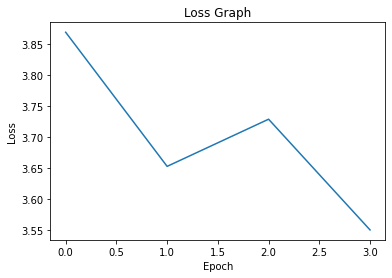

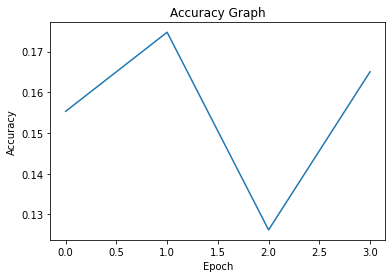

In [133]:
import matplotlib.pyplot as plt
plt.plot(training_loss)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(training_accuracy)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

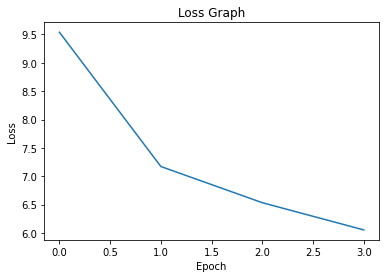

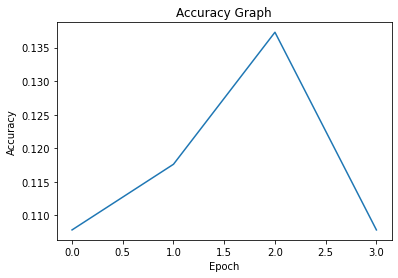

In [134]:
plt.plot(validation_loss)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(validation_accuracy)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [84]:
model = DAN(num_class=args.num_class, num_head=args.num_head)

C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


pretrained True


In [85]:
from pathlib import Path
checkpoint = torch.load('./datasets/checkpoints/affecnet8_epoch4_acc0.0882.pth')
# model.load_state_dict(checkpoint)

In [64]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [63]:
args = parse_args()
data_transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])]) 

In [140]:
val_dataset = datasets.ImageFolder(f'{args.aff_path}val_set/', transform = data_transforms_val)    # loading statically
if args.num_class == 7:   # ignore the 8-th class 
    idx = [i for i in range(len(val_dataset)) if val_dataset.imgs[i][1] != 7]
    val_dataset = data.Subset(val_dataset, idx)

print('Validation set size:', val_dataset.__len__())

val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size = args.batch_size,
#                                                num_workers = args.workers,
                                         num_workers = 0,
                                           shuffle = False,  
                                           pin_memory = True)

Validation set size: 102


In [141]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# if torch.cuda.is_available():
#     torch.backends.cudnn.benchmark = True
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.enabled = True
# print("args.num_class",args.num_class)

# model = DAN(num_class=args.num_class, num_head=args.num_head)
# model.to(device)

In [142]:
criterion_cls = torch.nn.CrossEntropyLoss().to(device)
criterion_af = AffinityLoss(device, num_class=args.num_class)
criterion_pt = PartitionLoss()
params = list(model.parameters()) + list(criterion_af.parameters())
optimizer = torch.optim.Adam(params,args.lr,weight_decay = 0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.6)
best_acc = 0

In [148]:
# epoch = 0
prediction_loss=[]
prediction_accuracy=[]
for epoch in tqdm(range(1, 4)):
    with torch.no_grad():
                running_loss = 0.0
                iter_cnt = 0
                bingo_cnt = 0
                sample_cnt = 0
                model.eval()
                for imgs, targets in val_loader:

                    imgs = imgs.to(device)
                    targets = targets.to(device)
                    out,feat,heads = model(imgs)

                    loss = criterion_cls(out,targets) + criterion_af(feat,targets) + criterion_pt(heads)

                    running_loss += loss
                    iter_cnt+=1
                    _, predicts = torch.max(out, 1)
                    correct_num  = torch.eq(predicts,targets)
                    bingo_cnt += correct_num.sum().cpu()
                    sample_cnt += out.size(0)

                running_loss = running_loss/iter_cnt   
                scheduler.step()

                acc = bingo_cnt.float()/float(sample_cnt)
                acc = np.around(acc.numpy(),4)
                best_acc = max(acc,best_acc)
                tqdm.write("[Epoch %d] Validation accuracy:%.4f. Loss:%.3f" % (epoch, acc, running_loss))
                tqdm.write("best_acc:" + str(best_acc))
                prediction_loss.append(running_loss.detach().cpu().numpy().tolist())
                prediction_accuracy.append(acc)

#             if args.num_class == 7 and  acc > 0.65:
#                 torch.save({'iter': epoch,
#                             'model_state_dict': model.state_dict(),
#                              'optimizer_state_dict': optimizer.state_dict(),},
#                             os.path.join('checkpoints', "affecnet7_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#                 tqdm.write('Model saved.')

#             elif args.num_class == 8 and  acc > 0.62:
#                 torch.save({'iter': epoch,
#                             'model_state_dict': model.state_dict(),
#                              'optimizer_state_dict': optimizer.state_dict(),},
#                             os.path.join('checkpoints', "affecnet8_epoch"+str(epoch)+"_acc"+str(acc)+".pth"))
#                 tqdm.write('Model saved.')

  1%|▊                                                                                 | 1/102 [00:04<08:24,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  2%|█▌                                                                                | 2/102 [00:10<08:26,  5.06s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  3%|██▍                                                                               | 3/102 [00:15<08:17,  5.03s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  4%|███▏                                                                              | 4/102 [00:20<08:09,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  5%|████                                                                              | 5/102 [00:24<07:59,  4.94s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  6%|████▊                                                                             | 6/102 [00:29<07:52,  4.92s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  7%|█████▋                                                                            | 7/102 [00:34<07:48,  4.93s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  8%|██████▍                                                                           | 8/102 [00:39<07:44,  4.95s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

  9%|███████▏                                                                          | 9/102 [00:44<07:35,  4.89s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 10%|███████▉                                                                         | 10/102 [00:49<07:31,  4.90s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 11%|████████▋                                                                        | 11/102 [00:54<07:27,  4.92s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 12%|█████████▌                                                                       | 12/102 [00:59<07:21,  4.91s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 13%|██████████▎                                                                      | 13/102 [01:04<07:22,  4.97s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 14%|███████████                                                                      | 14/102 [01:09<07:14,  4.94s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 15%|███████████▉                                                                     | 15/102 [01:14<07:08,  4.93s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 16%|████████████▋                                                                    | 16/102 [01:19<07:09,  4.99s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 17%|█████████████▌                                                                   | 17/102 [01:24<07:03,  4.98s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 18%|██████████████▎                                                                  | 18/102 [01:29<07:03,  5.04s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 19%|███████████████                                                                  | 19/102 [01:34<06:54,  4.99s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 20%|███████████████▉                                                                 | 20/102 [01:39<06:49,  4.99s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 21%|████████████████▋                                                                | 21/102 [01:44<06:41,  4.95s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 22%|█████████████████▍                                                               | 22/102 [01:49<06:37,  4.97s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 23%|██████████████████▎                                                              | 23/102 [01:54<06:44,  5.12s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 24%|███████████████████                                                              | 24/102 [01:59<06:40,  5.13s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 25%|███████████████████▊                                                             | 25/102 [02:04<06:31,  5.09s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 25%|████████████████████▋                                                            | 26/102 [02:09<06:22,  5.03s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 26%|█████████████████████▍                                                           | 27/102 [02:14<06:15,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 27%|██████████████████████▏                                                          | 28/102 [02:19<06:07,  4.97s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 28%|███████████████████████                                                          | 29/102 [02:24<06:01,  4.96s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 29%|███████████████████████▊                                                         | 30/102 [02:29<05:50,  4.87s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 30%|████████████████████████▌                                                        | 31/102 [02:34<05:47,  4.89s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 31%|█████████████████████████▍                                                       | 32/102 [02:38<05:43,  4.91s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 32%|██████████████████████████▏                                                      | 33/102 [02:43<05:40,  4.93s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 33%|███████████████████████████                                                      | 34/102 [02:49<05:41,  5.02s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 34%|███████████████████████████▊                                                     | 35/102 [02:54<05:35,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 35%|████████████████████████████▌                                                    | 36/102 [02:59<05:29,  4.99s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 36%|█████████████████████████████▍                                                   | 37/102 [03:04<05:27,  5.05s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 37%|██████████████████████████████▏                                                  | 38/102 [03:09<05:23,  5.06s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 38%|██████████████████████████████▉                                                  | 39/102 [03:14<05:19,  5.07s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 39%|███████████████████████████████▊                                                 | 40/102 [03:19<05:16,  5.10s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 40%|████████████████████████████████▌                                                | 41/102 [03:24<05:07,  5.04s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 41%|█████████████████████████████████▎                                               | 42/102 [03:29<04:58,  4.97s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 42%|██████████████████████████████████▏                                              | 43/102 [03:34<04:54,  4.98s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 43%|██████████████████████████████████▉                                              | 44/102 [03:39<04:50,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 44%|███████████████████████████████████▋                                             | 45/102 [03:44<04:45,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 45%|████████████████████████████████████▌                                            | 46/102 [03:49<04:37,  4.95s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 46%|█████████████████████████████████████▎                                           | 47/102 [03:54<04:32,  4.95s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 47%|██████████████████████████████████████                                           | 48/102 [03:59<04:25,  4.92s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 48%|██████████████████████████████████████▉                                          | 49/102 [04:04<04:22,  4.96s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 49%|███████████████████████████████████████▋                                         | 50/102 [04:09<04:18,  4.96s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 50%|████████████████████████████████████████▌                                        | 51/102 [04:13<04:12,  4.95s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 51%|█████████████████████████████████████████▎                                       | 52/102 [04:19<04:09,  4.98s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 52%|██████████████████████████████████████████                                       | 53/102 [04:24<04:05,  5.02s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 53%|██████████████████████████████████████████▉                                      | 54/102 [04:29<04:00,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 54%|███████████████████████████████████████████▋                                     | 55/102 [04:33<03:52,  4.95s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 55%|████████████████████████████████████████████▍                                    | 56/102 [04:39<03:49,  4.99s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 56%|█████████████████████████████████████████████▎                                   | 57/102 [04:44<03:45,  5.02s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 57%|██████████████████████████████████████████████                                   | 58/102 [04:49<03:40,  5.02s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 58%|██████████████████████████████████████████████▊                                  | 59/102 [04:54<03:34,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 59%|███████████████████████████████████████████████▋                                 | 60/102 [04:59<03:32,  5.05s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 60%|████████████████████████████████████████████████▍                                | 61/102 [05:04<03:25,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 61%|█████████████████████████████████████████████████▏                               | 62/102 [05:09<03:22,  5.07s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 62%|██████████████████████████████████████████████████                               | 63/102 [05:14<03:19,  5.12s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 63%|██████████████████████████████████████████████████▊                              | 64/102 [05:19<03:13,  5.08s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 64%|███████████████████████████████████████████████████▌                             | 65/102 [05:24<03:06,  5.04s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 65%|████████████████████████████████████████████████████▍                            | 66/102 [05:29<03:01,  5.05s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 66%|█████████████████████████████████████████████████████▏                           | 67/102 [05:34<02:57,  5.06s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 67%|██████████████████████████████████████████████████████                           | 68/102 [05:39<02:51,  5.03s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 68%|██████████████████████████████████████████████████████▊                          | 69/102 [05:44<02:45,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 69%|███████████████████████████████████████████████████████▌                         | 70/102 [05:49<02:37,  4.93s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 70%|████████████████████████████████████████████████████████▍                        | 71/102 [05:54<02:33,  4.96s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 71%|█████████████████████████████████████████████████████████▏                       | 72/102 [05:59<02:29,  4.98s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 72%|█████████████████████████████████████████████████████████▉                       | 73/102 [06:04<02:23,  4.96s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 73%|██████████████████████████████████████████████████████████▊                      | 74/102 [06:09<02:20,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 74%|███████████████████████████████████████████████████████████▌                     | 75/102 [06:14<02:14,  4.99s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 75%|████████████████████████████████████████████████████████████▎                    | 76/102 [06:19<02:09,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 75%|█████████████████████████████████████████████████████████████▏                   | 77/102 [06:24<02:05,  5.00s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 76%|█████████████████████████████████████████████████████████████▉                   | 78/102 [06:29<02:02,  5.10s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 77%|██████████████████████████████████████████████████████████████▋                  | 79/102 [06:34<01:56,  5.07s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 78%|███████████████████████████████████████████████████████████████▌                 | 80/102 [06:39<01:51,  5.06s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 79%|████████████████████████████████████████████████████████████████▎                | 81/102 [06:44<01:45,  5.04s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 80%|█████████████████████████████████████████████████████████████████                | 82/102 [06:49<01:40,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 81%|█████████████████████████████████████████████████████████████████▉               | 83/102 [06:54<01:35,  5.03s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 82%|██████████████████████████████████████████████████████████████████▋              | 84/102 [06:59<01:30,  5.04s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 83%|███████████████████████████████████████████████████████████████████▌             | 85/102 [07:05<01:26,  5.09s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 84%|████████████████████████████████████████████████████████████████████▎            | 86/102 [07:10<01:21,  5.07s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 85%|█████████████████████████████████████████████████████████████████████            | 87/102 [07:15<01:15,  5.06s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 86%|█████████████████████████████████████████████████████████████████████▉           | 88/102 [07:20<01:10,  5.06s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 87%|██████████████████████████████████████████████████████████████████████▋          | 89/102 [07:25<01:05,  5.05s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 88%|███████████████████████████████████████████████████████████████████████▍         | 90/102 [07:30<01:00,  5.04s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 89%|████████████████████████████████████████████████████████████████████████▎        | 91/102 [07:35<00:55,  5.02s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 90%|█████████████████████████████████████████████████████████████████████████        | 92/102 [07:40<00:49,  4.98s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 91%|█████████████████████████████████████████████████████████████████████████▊       | 93/102 [07:45<00:45,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 92%|██████████████████████████████████████████████████████████████████████████▋      | 94/102 [07:50<00:39,  4.96s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 93%|███████████████████████████████████████████████████████████████████████████▍     | 95/102 [07:55<00:34,  4.97s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 94%|████████████████████████████████████████████████████████████████████████████▏    | 96/102 [08:00<00:29,  4.99s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 95%|█████████████████████████████████████████████████████████████████████████████    | 97/102 [08:05<00:25,  5.02s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 96%|█████████████████████████████████████████████████████████████████████████████▊   | 98/102 [08:10<00:20,  5.07s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 97%|██████████████████████████████████████████████████████████████████████████████▌  | 99/102 [08:15<00:15,  5.05s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 100/102 [08:20<00:10,  5.06s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

 99%|███████████████████████████████████████████████████████████████████████████████▏| 101/102 [08:25<00:05,  5.09s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [08:30<00:00,  5.01s/it]

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

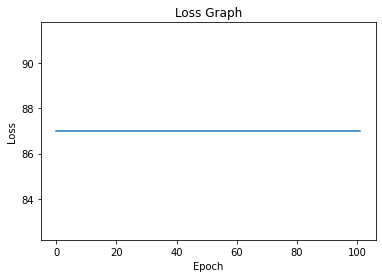

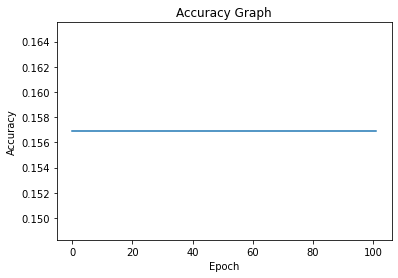

In [149]:
plt.plot(prediction_loss)
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(prediction_accuracy)
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [161]:
y_pred = []
y_true = []

for imgs, targets in val_loader:
    imgs = imgs.to(device)
    targets = targets.to(device)
    out,feat,heads = model(imgs)
    _, predicts = torch.max(out, 1)
    correct_num  = torch.eq(predicts,targets)
    bingo_cnt += correct_num.sum().cpu()
    sample_cnt += out.size(0)
    output =(torch.max(out, 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    y_true.extend(targets.detach().cpu().numpy().tolist())

out, x, heads tensor([[-1.3449e+01, -6.4683e+01,  1.4490e+02, -3.7468e+01, -7.8923e+01,
          9.6773e+01, -7.7185e+01, -1.3330e+02],
        [-1.2497e+01, -5.9494e+00,  5.5302e+00, -1.0184e+01, -9.5916e+00,
          1.5679e+01, -1.2520e+01, -2.2029e+01],
        [ 8.8979e+00, -4.9117e+01,  7.5444e+01, -3.4801e+01, -4.0453e+01,
          7.8107e+01, -5.5903e+01, -1.0198e+02],
        [-1.8822e+01, -5.1583e+01,  6.7767e+01, -3.8922e+01, -3.3972e+01,
          9.4194e+01, -3.8180e+01, -1.3872e+02],
        [-7.4412e+00, -1.0861e+02,  6.1905e+01, -3.2429e+01, -1.2250e+02,
          1.2127e+02, -9.8932e+01, -1.0787e+02],
        [-6.5072e+00, -2.6271e+01,  4.6871e+01, -4.1389e+00, -4.1025e+01,
          3.7695e+01, -2.7042e+01, -7.7131e+01],
        [-2.4410e+01, -6.7015e+01,  6.3313e+01, -2.0298e+01, -9.7346e+01,
          8.1776e+01, -4.2505e+01, -1.1976e+02],
        [ 6.7329e+00, -6.8439e+01,  8.3459e+01, -2.0278e+01, -7.9940e+01,
          9.8534e+01, -7.1795e+01, -1.1811e+02],
  

In [162]:
print(bingo_cnt,sample_cnt)

tensor(80) 510


In [170]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
# y_pred
# y_true
classes = ('anger', 'contempt', 'disgust', 'fear', 'happy',
        'neutral', 'sad', 'surprise')

In [171]:
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])

<AxesSubplot:>

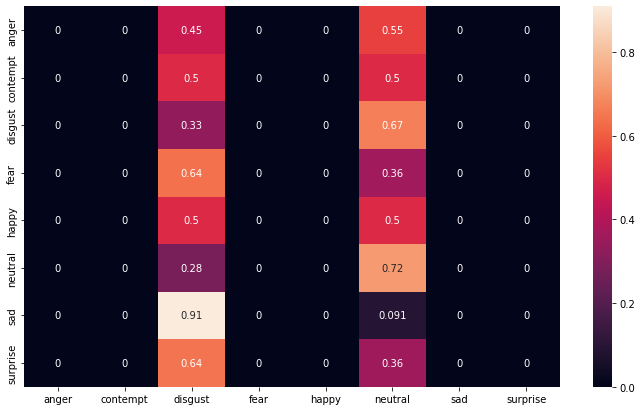

In [172]:
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [179]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [185]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, y_true)
print('Accuracy: %f' ,accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_pred, y_true,pos_label='positive',average='micro')
print('Precision: %f',  precision)
# recall: tp / (tp + fn)
recall = recall_score(y_pred, y_true,pos_label='positive',average='micro')
print('Recall: %f',  recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, y_true,pos_label='positive',average='micro')
print('F1 score: %f',  f1)
auc = roc_auc_score(y_pred, y_true)
print('ROC AUC: %f',  auc)

Accuracy: %f 0.1568627450980392
Precision: %f 0.1568627450980392
Recall: %f 0.1568627450980392
F1 score: %f 0.1568627450980392
ROC AUC: %f 0.4231805929919137


C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
C:\Users\sudip\anaconda3\envs\tf1\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
